In [1]:
import os

import pandas as pd
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

from os.path import join as pjoin
from scipy.stats import linregress

# Step 1: Loading the data from the .mat files
The code loops through the .mat files for each rat, processsing technique and brain region. \
The value of interest is the mean concentration of the metabolite across the brain region (averaged over the relevant voxels).

In [ ]:
# Define constants
RATS_ID = ['0804', '1304', '1810', '3105']
EXPERIMENTS = ['Filtered', 'Raw', 'LR-TGV', 'MP-PCA']
REGIONS = ['Hippocampus', 'Striatum']
MET_NAMES = [
    "Mac", "Cr", "PCr", "Ins", "NAA", "Tau", "PCho", "GPC", "Glu", "Gln", "Ala",
    "Asc", "Asp", "GABA", "Glc", "GSH", "Lac", "NAAG", "PE", "GPC +PCho", "NAA+NAAG", "Glu+Gln",  "Cr+PCr"
]

MET_IGNORED = {"Ala", "Asp", "Cr"}  # Remove specific metabolites we are not interesteed in
DATA_PATH = 'data/Rat_'

# Creating a dataframe to store the data
COLUMN_NAMES = ['rat_id', 'processing', 'region', 'metabolite', 'mean_conc', 'mean_diff_vs_filtered', 'mean_diff_MP_vs_LR']
df = pd.DataFrame(columns=COLUMN_NAMES)

# MultiIndex for more structured indexing
df.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)

# Iterate through experiments, rats, and regions
for experiment in EXPERIMENTS:
    for rat_id in RATS_ID:
        file_path = os.path.join(DATA_PATH + rat_id, experiment)
        for region in REGIONS:
            mat_fname = pjoin(file_path, region + '_L+R.mat')

            # Load the .mat file
            mat_contents = sio.loadmat(mat_fname)

            # Extract mean and standard deviation concentrations
            met_conc = mat_contents['results']['met_conc'][0, 0]
            mean_conc_rel = met_conc['mean_conc_rel'][0]

            # Loop through metabolites
            for i, met_name in enumerate(MET_NAMES):
                if met_name in MET_IGNORED:
                    continue  # Skip ignored metabolites
                
                # Retrieving the mean metabolite concentration
                met_mean = mean_conc_rel[i][0][0]
                
                # Initialize differences of concentrations between preprocessing techniques
                mean_diff_vs_filtered = np.nan
                mean_diff_MP_vs_LR = np.nan

                # Adding the difference w.r.t. the Filtered data used as Golden Standard
                if experiment != 'Filtered':
                    # Retrieve Filtered data for this rat, region, and metabolite
                    filtered_mean = df.loc[(rat_id, 'Filtered', region, met_name), 'mean_conc']
                    
                    # Computing the relative difference
                    mean_diff_vs_filtered = 100*(met_mean - filtered_mean) / filtered_mean if filtered_mean != 0 else 0
                   
                    # Adding the difference compared to the LR-TGV preprocessing for the MP-PCA technique
                    if experiment == 'MP-PCA':
                        # Retrieve LR-TGV data for this rat, region, and metabolite
                        LR_mean = df.loc[(rat_id, 'LR-TGV', region, met_name), 'mean_conc']

                        # Computing the relative difference 
                        mean_diff_MP_vs_LR = 100*(met_mean - LR_mean) / LR_mean if LR_mean != 0 else 0
                
                # Add data to the dataframe
                new_row = pd.DataFrame([[
                    rat_id, experiment, region, met_name, met_mean,
                    mean_diff_vs_filtered, mean_diff_MP_vs_LR
                ]], columns=COLUMN_NAMES)

                # Set MultiIndex for the new row
                new_row.set_index(['rat_id', 'processing', 'region', 'metabolite'], inplace=True)
                df = pd.concat([df, new_row])

# Ensure the dataframe is sorted by MultiIndex
df.sort_index(inplace=True)

# Reset the index for easier access in later processing
df = df.reset_index()

/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_23966/3253958073.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_23966/3253958073.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row])
/var/folders/5p/8l0d9tj151bc4tsfrd5r93480000gn/T/ipykernel_23966/3253958073.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. 

## Step 1.2 Verify which Metabolites have 0 mean concentration

In [3]:
print(df[(df['processing'] == 'Filtered') & (df['mean_conc'] == 0)].shape[0], 'Entries for The Filtered Data')
df[(df['processing'] == 'Filtered') & (df['mean_conc'] == 0)]

12 Entries for The Filtered Data


,rat_id,processing,region,metabolite,mean_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
3,0804,Filtered,Hippocampus,GPC,0.0,NaN,NaN
6,0804,Filtered,Hippocampus,Glc,0.0,NaN,NaN
18,0804,Filtered,Hippocampus,PE,0.0,NaN,NaN
166,1304,Filtered,Hippocampus,Glc,0.0,NaN,NaN
198,1304,Filtered,Striatum,PE,0.0,NaN,NaN
323,1810,Filtered,Hippocampus,GPC,0.0,NaN,NaN
326,1810,Filtered,Hippocampus,Glc,0.0,NaN,NaN
338,1810,Filtered,Hippocampus,PE,0.0,NaN,NaN
343,1810,Filtered,Striatum,GPC,0.0,NaN,NaN
358,1810,Filtered,Striatum,PE,0.0,NaN,NaN


In [4]:
print(df[(df['processing'] == 'LR-TGV') & (df['mean_conc'] == 0)].shape[0], 'Entries for The LR-TGV Data')
df[(df['processing'] == 'LR-TGV') & (df['mean_conc'] == 0)]

15 Entries for The LR-TGV Data


,rat_id,processing,region,metabolite,mean_conc,mean_diff_vs_filtered,mean_diff_MP_vs_LR
46,0804,LR-TGV,Hippocampus,Glc,0.0,0.0,NaN
51,0804,LR-TGV,Hippocampus,Lac,0.0,-100.0,NaN
58,0804,LR-TGV,Hippocampus,PE,0.0,0.0,NaN
66,0804,LR-TGV,Striatum,Glc,0.0,-100.0,NaN
71,0804,LR-TGV,Striatum,Lac,0.0,-100.0,NaN
75,0804,LR-TGV,Striatum,NAAG,0.0,-100.0,NaN
206,1304,LR-TGV,Hippocampus,Glc,0.0,0.0,NaN
211,1304,LR-TGV,Hippocampus,Lac,0.0,-100.0,NaN
215,1304,LR-TGV,Hippocampus,NAAG,0.0,-100.0,NaN
231,1304,LR-TGV,Striatum,Lac,0.0,-100.0,NaN


# Step 2: Data Analysis

## Plot A) Plotting the difference of concentration compared to filtered data for each preprocessing
Aggregating bypreprocessing, averaging over the 4 rats the difference of concentration compared to filtered data for each metabolite

### Defining the variables of interest

In [6]:
""" Hippocampus """
# Hippocampus: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Hipp_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Hipp_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

# Hippocampus: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Hipp_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Hipp_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

# Hippocampus: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Hipp_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Hipp_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Hippocampus')].groupby('metabolite').mean_diff_vs_filtered.std()

""" Striatum """
# Striatum: LR-TGV vs Filtered (Average over all Rats for each metabolite)
LR_Stri_vs_Filtered_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
LR_Stri_vs_Filtered_std = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: MP-PCA vs Filtered (Average over all Rats for each metabolite)
MP_Stri_vs_Filtered_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
MP_Stri_vs_Filtered_std = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Striatum: Raw vs Filtered (Average over all Rats for each metabolite)
Raw_Stri_vs_Filtered_mean = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.mean()
Raw_Stri_vs_Filtered_std = df[(df['processing']=='Raw') & (df['region']=='Striatum')].groupby('metabolite').mean_diff_vs_filtered.std()

# Selecting the color palette
colors = sns.color_palette('cool', 3)
print("Color Palette Used")
colors

Color Palette Used


[(0.25098039215686274, 0.7490196078431373, 1.0),
 (0.5019607843137255, 0.4980392156862745, 1.0),
 (0.7529411764705882, 0.24705882352941178, 1.0)]

### Plot A.1) Hippocampus

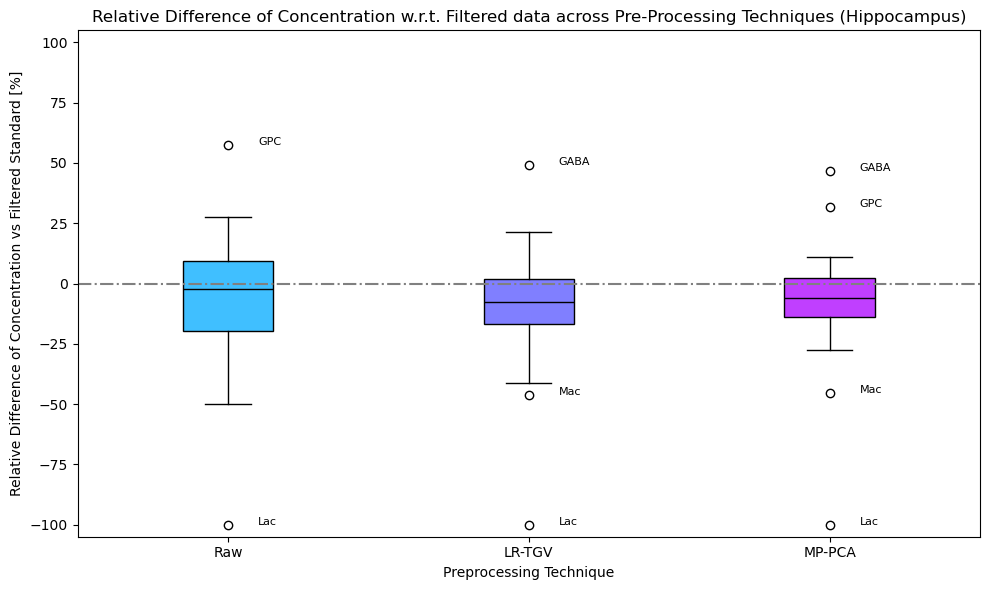

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = ["Raw", "LR-TGV", "MP-PCA"]
y_data = [Raw_Hipp_vs_Filtered_mean, LR_Hipp_vs_Filtered_mean, MP_Hipp_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)
plt.axhline(0, color="gray", linestyle="-.")

plt.title('Relative Difference of Concentration w.r.t. Filtered data across Pre-Processing Techniques (Hippocampus)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')
ax.set_ylim([-105,105])
plt.tight_layout()
plt.show()


### Plot A.2)  Striatum

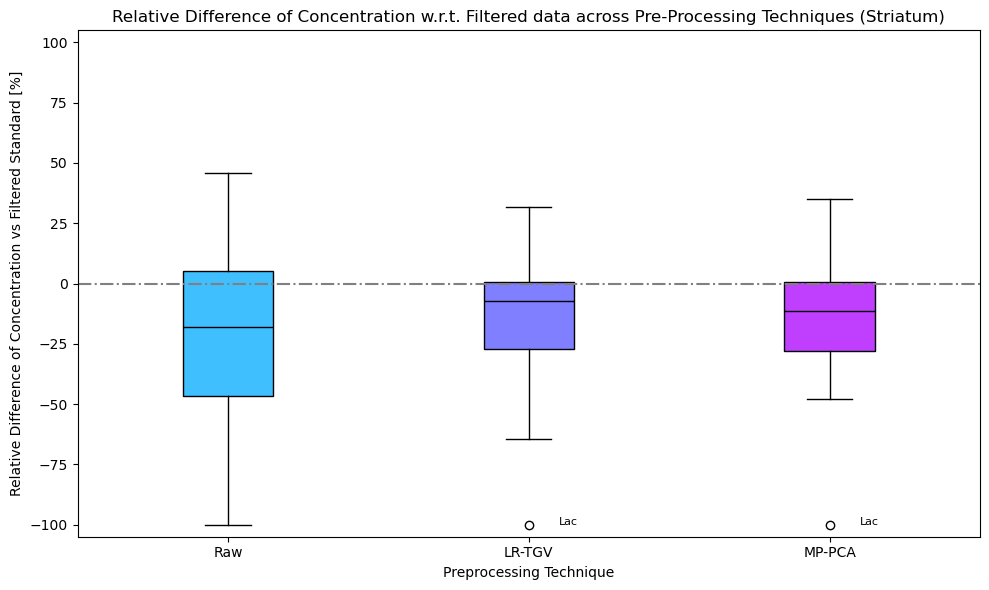

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
labels = [ "Raw", "LR-TGV", "MP-PCA"]
y_data = [Raw_Stri_vs_Filtered_mean, LR_Stri_vs_Filtered_mean, MP_Stri_vs_Filtered_mean]

# Create the boxplot
bplot = ax.boxplot(x=y_data, vert=True, patch_artist=True, tick_labels=labels)
plt.axhline(0, color="gray", linestyle="-.")

plt.title('Relative Difference of Concentration w.r.t. Filtered data across Pre-Processing Techniques (Striatum)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Set the facecolor for each box
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

# Define the offset for labels
x_offset = 0.1  # Horizontal offset
y_offset = 0.02  # Vertical offset

# Label the outliers
for i, (series, fliers) in enumerate(zip(y_data, bplot['fliers'])):
    y_outliers = fliers.get_ydata()  # Get the y-coordinates of the outliers
    for j, y in enumerate(y_outliers):
        index = series[series == y].index  # Get the index of the outlier
        if not index.empty:  # Check if an index was found
            # Adjust the x and y positions with the offsets
            ax.text(
                i + 1 + x_offset,  # Shift horizontally
                y + y_offset,      # Shift vertically
                f'{index[0]}', 
                ha='left', fontsize=8, color='black'
            )
# Change the color of the median lines
for median in bplot['medians']:
    median.set_color('black')

#sns.despine()
ax.set_ylim([-105,105])
plt.tight_layout()
plt.show()


## Statistical Analysis of distribution of relative errors


In [9]:
from scipy.stats import ttest_1samp

processings = ['Hipp_Raw', 'Hipp_LR', 'Hipp_MP', 'Stri_Raw', 'Stri_LR', 'Stri_MP']
mean_data_processing = [Raw_Hipp_vs_Filtered_mean, LR_Hipp_vs_Filtered_mean, MP_Hipp_vs_Filtered_mean, Raw_Stri_vs_Filtered_mean, LR_Stri_vs_Filtered_mean, MP_Stri_vs_Filtered_mean]

for i, data_processing in enumerate(mean_data_processing):

    t_stat, p_val = ttest_1samp(data_processing, 0)  # Compare mean to 0
    print('***')
    print(f"One-sample t-test for {processings[i]}: t={round(t_stat,3)}, p={round(p_val,3)}")
    if p_val < 0.05:
        print(f"==> Mean relative error for {processings[i]} is significantly different from 0.\n")
    else:
        print(f"==> No significant shift in mean relative error for {processings[i]}.\n")


***
One-sample t-test for Hipp_Raw: t=-1.099, p=0.286
==> No significant shift in mean relative error for Hipp_Raw.

***
One-sample t-test for Hipp_LR: t=-1.678, p=0.11
==> No significant shift in mean relative error for Hipp_LR.

***
One-sample t-test for Hipp_MP: t=-1.253, p=0.225
==> No significant shift in mean relative error for Hipp_MP.

***
One-sample t-test for Stri_Raw: t=-2.526, p=0.021
==> Mean relative error for Stri_Raw is significantly different from 0.

***
One-sample t-test for Stri_LR: t=-2.521, p=0.021
==> Mean relative error for Stri_LR is significantly different from 0.

***
One-sample t-test for Stri_MP: t=-2.317, p=0.032
==> Mean relative error for Stri_MP is significantly different from 0.



## Plot B) Relative Difference of concentration for Each Metabolite Across the Preprocessing Techniques
(Averaged over the 4 rats)

### Plot B.1) Hippocampus

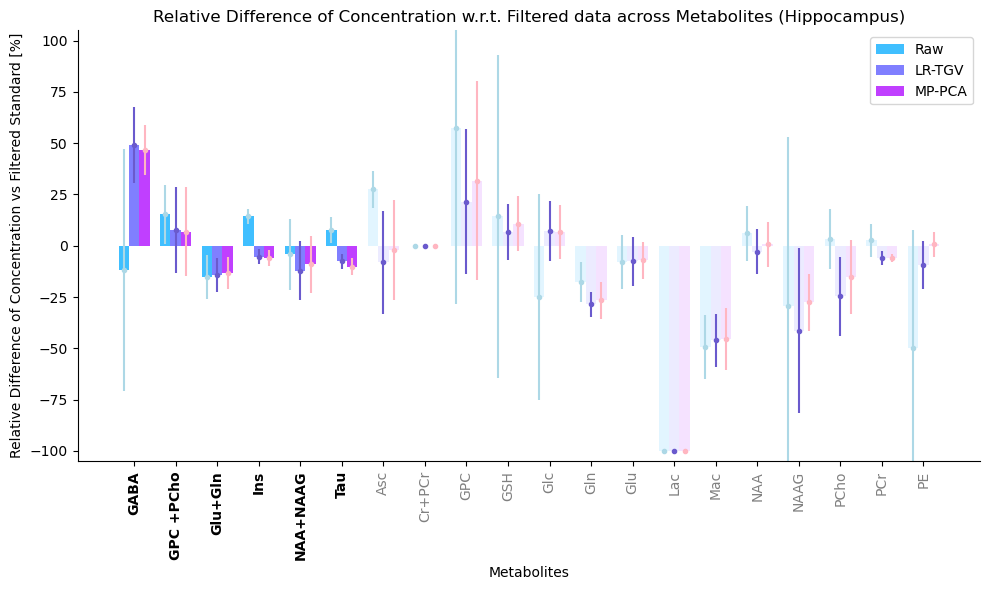

In [ ]:
# Define the metabolites of interest for the hippocampus
MET_OF_INTEREST = {"Ins", "GABA", "Tau", "Glu+Gln", "NAA+NAAG", "GPC +PCho"}

# Sort the data by metabolites of interest first
sorted_keys = sorted(LR_Hipp_vs_Filtered_mean.keys(), key=lambda x: x not in MET_OF_INTEREST)

# Reorder the data based on sorted keys
LR_Hipp_vs_Filtered_mean = {key: LR_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Hipp_vs_Filtered_mean = {key: Raw_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
MP_Hipp_vs_Filtered_mean = {key: MP_Hipp_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Hipp_vs_Filtered_std = {key: Raw_Hipp_vs_Filtered_std[key] for key in sorted_keys}
LR_Hipp_vs_Filtered_std = {key: LR_Hipp_vs_Filtered_std[key] for key in sorted_keys}
MP_Hipp_vs_Filtered_std = {key: MP_Hipp_vs_Filtered_std[key] for key in sorted_keys}

X_axis = np.arange(len(LR_Hipp_vs_Filtered_mean))  # Shared x-axis for all categories

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Plot the bars and highlight metabolites of interest
for i, key in enumerate(LR_Hipp_vs_Filtered_mean.keys()):
    if key in MET_OF_INTEREST:
        # Highlighted metabolites
        ax.bar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], bar_width, color=colors[0], label='Raw' if i == 0 else "")
        ax.bar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], bar_width, color=colors[1], label='LR-TGV' if i == 0 else "")
        ax.bar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], bar_width, color=colors[2], label='MP-PCA' if i == 0 else "")
    else:
        # Non-highlighted metabolites with increased transparency (lower alpha)
        ax.bar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], bar_width, color=colors[0], alpha=0.15)
        ax.bar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], bar_width, color=colors[1], alpha=0.15)
        ax.bar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], bar_width, color=colors[2], alpha=0.15)

    # Add error bars
    ax.errorbar(X_axis[i] - bar_width, Raw_Hipp_vs_Filtered_mean[key], yerr=Raw_Hipp_vs_Filtered_std[key], fmt='.', color="lightblue")
    ax.errorbar(X_axis[i], LR_Hipp_vs_Filtered_mean[key], yerr=LR_Hipp_vs_Filtered_std[key], fmt='.', color="slateblue")
    ax.errorbar(X_axis[i] + bar_width, MP_Hipp_vs_Filtered_mean[key], yerr=MP_Hipp_vs_Filtered_std[key], fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Hipp_vs_Filtered_mean.keys())

# Highlight the x-axis labels for metabolites of interest
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() in MET_OF_INTEREST:
        label.set_fontweight('bold')
    else:
        label.set_color('gray')  

plt.xticks(rotation=90)
ax.set_ylim([-105,105])

# Titles and labels
ax.set_title("Relative Difference of Concentration w.r.t. Filtered data across Metabolites (Hippocampus)")
plt.xlabel("Metabolites")
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Legend and styling
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


### Plot B.2) Striatum

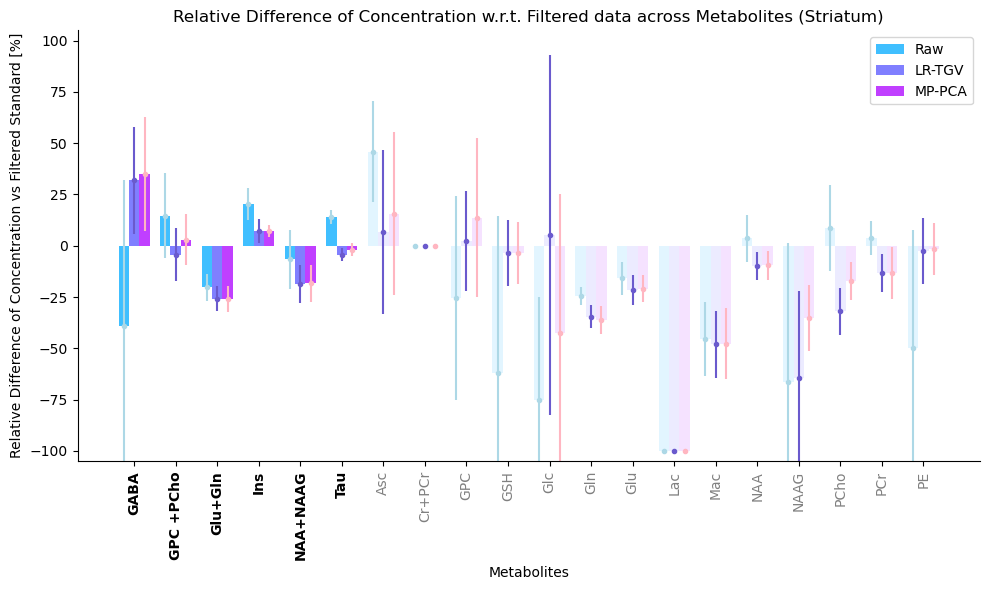

In [ ]:
# Sort the data by metabolites of interest first
sorted_keys = sorted(LR_Stri_vs_Filtered_mean.keys(), key=lambda x: x not in MET_OF_INTEREST)

# Reorder the data based on sorted keys
LR_Stri_vs_Filtered_mean = {key: LR_Stri_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Stri_vs_Filtered_mean = {key: Raw_Stri_vs_Filtered_mean[key] for key in sorted_keys}
MP_Stri_vs_Filtered_mean = {key: MP_Stri_vs_Filtered_mean[key] for key in sorted_keys}
Raw_Stri_vs_Filtered_std = {key: Raw_Stri_vs_Filtered_std[key] for key in sorted_keys}
LR_Stri_vs_Filtered_std = {key: LR_Stri_vs_Filtered_std[key] for key in sorted_keys}
MP_Stri_vs_Filtered_std = {key: MP_Stri_vs_Filtered_std[key] for key in sorted_keys}

X_axis = np.arange(len(LR_Stri_vs_Filtered_mean))  # Shared x-axis for all categories

fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.25

# Plot the bars and highlight metabolites of interest
for i, key in enumerate(LR_Stri_vs_Filtered_mean.keys()):
    if key in MET_OF_INTEREST:
        # Highlighted metabolites
        ax.bar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], bar_width, color=colors[0], label='Raw' if i == 0 else "")
        ax.bar(X_axis[i], LR_Stri_vs_Filtered_mean[key], bar_width, color=colors[1], label='LR-TGV' if i == 0 else "")
        ax.bar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], bar_width, color=colors[2], label='MP-PCA' if i == 0 else "")
    else:
        # Non-highlighted metabolites with increased transparency (lower alpha)
        ax.bar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], bar_width, color=colors[0], alpha=0.15)
        ax.bar(X_axis[i], LR_Stri_vs_Filtered_mean[key], bar_width, color=colors[1], alpha=0.15)
        ax.bar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], bar_width, color=colors[2], alpha=0.15)

    # Add error bars
    ax.errorbar(X_axis[i] - bar_width, Raw_Stri_vs_Filtered_mean[key], yerr=Raw_Stri_vs_Filtered_std[key], fmt='.', color="lightblue")
    ax.errorbar(X_axis[i], LR_Stri_vs_Filtered_mean[key], yerr=LR_Stri_vs_Filtered_std[key], fmt='.', color="slateblue")
    ax.errorbar(X_axis[i] + bar_width, MP_Stri_vs_Filtered_mean[key], yerr=MP_Stri_vs_Filtered_std[key], fmt='.', color="lightpink")

# Set x-axis ticks and labels
ax.set_xticks(X_axis)
ax.set_xticklabels(LR_Stri_vs_Filtered_mean.keys())

# Highlight the x-axis labels for metabolites of interest
for i, label in enumerate(ax.get_xticklabels()):
    if label.get_text() in MET_OF_INTEREST:
        label.set_fontweight('bold')
    else:
        label.set_color('gray')  

plt.xticks(rotation=90)
ax.set_ylim([-105,105])

# Titles and labels
ax.set_title("Relative Difference of Concentration w.r.t. Filtered data across Metabolites (Striatum)")
plt.xlabel("Metabolites")
plt.ylabel('Relative Difference of Concentration vs Filtered Standard [%]')

# Legend and styling
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()


## Plot C) Inconcistencies of Concentration across Preprocessing Techniques vs Concentration of the Metabolites

In [12]:
# LR-TGV vs MP-PCA
MP_vs_LR_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_MP_vs_LR']]
MP_vs_LR_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_MP_vs_LR']]

# LR-TGV vs Filter
Filtered_vs_LR_Hipp_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_LR_Stri_mean = df[(df['processing']=='LR-TGV') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]

# MP-PCA vs Filter
Filtered_vs_MP_Hipp_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Hippocampus')][['mean_conc', 'mean_diff_vs_filtered']]
Filtered_vs_MP_Stri_mean = df[(df['processing']=='MP-PCA') & (df['region']=='Striatum')][['mean_conc', 'mean_diff_vs_filtered']]


### Plot C.1) Hippocampus (Individual Points)

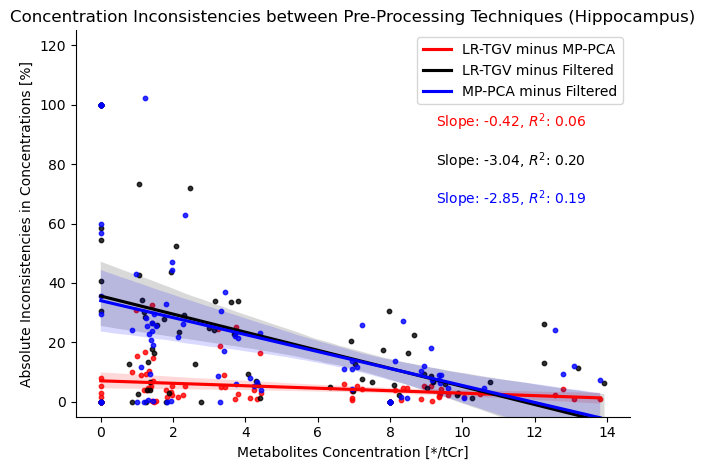

In [13]:
# Create the figure and axes
fig, ax = plt.subplots()

# Calculate and plot regression for MP-PCA vs LR-TGV
slope_mp_lr, intercept_mp_lr, r_value_mp_lr, p_value_mp_lr, std_err_mp_lr = linregress(
    MP_vs_LR_Hipp_mean.mean_conc, abs(MP_vs_LR_Hipp_mean.mean_diff_MP_vs_LR)
)
sns.regplot(
    x=MP_vs_LR_Hipp_mean.mean_conc,
    y=abs(MP_vs_LR_Hipp_mean.mean_diff_MP_vs_LR),
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_mp_lr:.2f}, $R^2$: {r_value_mp_lr**2:.2f}",
    xy=(0.65, 0.75),
    xycoords="axes fraction",
    color="r",
    fontsize=10,
)

# Calculate and plot regression for Filtered vs LR-TGV
slope_filtered_lr, intercept_filtered_lr, r_value_filtered_lr, p_value_filtered_lr, std_err_filtered_lr = linregress(
    Filtered_vs_LR_Hipp_mean.mean_conc, abs(Filtered_vs_LR_Hipp_mean.mean_diff_vs_filtered)
)
sns.regplot(
    x=Filtered_vs_LR_Hipp_mean.mean_conc,
    y=abs(Filtered_vs_LR_Hipp_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'LR-TGV minus Filtered', 'color': 'black'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_filtered_lr:.2f}, $R^2$: {r_value_filtered_lr**2:.2f}",
    xy=(0.65, 0.65),
    xycoords="axes fraction",
    color="black",
    fontsize=10,
)

# Calculate and plot regression for Filtered vs MP-PCA
slope_filtered_mp, intercept_filtered_mp, r_value_filtered_mp, p_value_filtered_mp, std_err_filtered_mp = linregress(
    Filtered_vs_MP_Hipp_mean.mean_conc, abs(Filtered_vs_MP_Hipp_mean.mean_diff_vs_filtered)
)
sns.regplot(
    x=Filtered_vs_MP_Hipp_mean.mean_conc,
    y=abs(Filtered_vs_MP_Hipp_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'MP-PCA minus Filtered', 'color': 'blue'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_filtered_mp:.2f}, $R^2$: {r_value_filtered_mp**2:.2f}",
    xy=(0.65, 0.55),
    xycoords="axes fraction",
    color="blue",
    fontsize=10,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_ylim([-5, 125])
ax.set_xlabel("Metabolites Concentration [*/tCr]")
ax.set_title("Concentration Inconsistencies between Pre-Processing Techniques (Hippocampus)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()


### Plot C.2) Striatum (Individual Points)

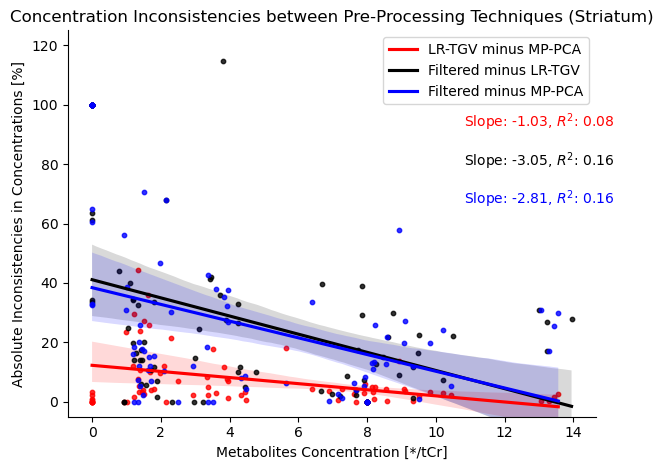

In [14]:
# Create the figure and axes
fig, ax = plt.subplots()

# Calculate and plot regression for MP-PCA vs LR-TGV
slope_mp_lr, intercept_mp_lr, r_value_mp_lr, p_value_mp_lr, std_err_mp_lr = linregress(
    MP_vs_LR_Stri_mean.mean_conc, abs(MP_vs_LR_Stri_mean.mean_diff_MP_vs_LR)
)
sns.regplot(
    x=MP_vs_LR_Stri_mean.mean_conc,
    y=abs(MP_vs_LR_Stri_mean.mean_diff_MP_vs_LR),
    scatter_kws={'color': 'r', 's': 10},
    line_kws={'label': 'LR-TGV minus MP-PCA', 'color': 'r'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_mp_lr:.2f}, $R^2$: {r_value_mp_lr**2:.2f}",
    xy=(0.75, 0.75),
    xycoords="axes fraction",
    color="r",
    fontsize=10,
)

# Calculate and plot regression for Filtered vs LR-TGV
slope_filtered_lr, intercept_filtered_lr, r_value_filtered_lr, p_value_filtered_lr, std_err_filtered_lr = linregress(
    Filtered_vs_LR_Stri_mean.mean_conc, abs(Filtered_vs_LR_Stri_mean.mean_diff_vs_filtered)
)
sns.regplot(
    x=Filtered_vs_LR_Stri_mean.mean_conc,
    y=abs(Filtered_vs_LR_Stri_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'black', 's': 10},
    line_kws={'label': 'Filtered minus LR-TGV', 'color': 'black'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_filtered_lr:.2f}, $R^2$: {r_value_filtered_lr**2:.2f}",
    xy=(0.75, 0.65),
    xycoords="axes fraction",
    color="black",
    fontsize=10,
)

# Calculate and plot regression for Filtered vs MP-PCA
slope_filtered_mp, intercept_filtered_mp, r_value_filtered_mp, p_value_filtered_mp, std_err_filtered_mp = linregress(
    Filtered_vs_MP_Stri_mean.mean_conc, abs(Filtered_vs_MP_Stri_mean.mean_diff_vs_filtered)
)
sns.regplot(
    x=Filtered_vs_MP_Stri_mean.mean_conc,
    y=abs(Filtered_vs_MP_Stri_mean.mean_diff_vs_filtered),
    scatter_kws={'color': 'blue', 's': 10},
    line_kws={'label': 'Filtered minus MP-PCA', 'color': 'blue'},
    ci=95,
    ax=ax,
)
ax.annotate(
    f"Slope: {slope_filtered_mp:.2f}, $R^2$: {r_value_filtered_mp**2:.2f}",
    xy=(0.75, 0.55),
    xycoords="axes fraction",
    color="blue",
    fontsize=10,
)

# Add labels, title, and legend
ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_ylim([-5, 125])
ax.set_xlabel("Metabolites Concentration [*/tCr]")
ax.set_title("Concentration Inconsistencies between Pre-Processing Techniques (Striatum)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()


### Defining functions to plot grouped concentrations

In [15]:
def categorize_concentration(conc):
    if conc <= 3:
        return 'Low'
    elif 3 < conc <= 8:
        return 'Medium'
    else:
        return 'High'
    
# Function to shift x-axis positions for each comparison
def shift_x_positions(x, offset):
    return x + offset

# Function to plot the Low-Medium and Medium-High regression lines
def plot_regressions(df, color, label, offset):
    # Separate the data into two groups: Low-Medium and Medium-High
    df_low_medium = df[df['concentration_group_numeric'] <= 1]  # Low + Medium
    df_medium_high = df[df['concentration_group_numeric'] >= 1]  # Medium + High

    # Plot regression lines for Low-Medium and Medium-High
    sns.regplot(
        x=shift_x_positions(df_low_medium['concentration_group_numeric'], offset),
        y=abs(df_low_medium['mean_diff_MP_vs_LR']) if 'mean_diff_MP_vs_LR' in df.columns else abs(df_low_medium['mean_diff_vs_filtered']),
        scatter_kws={'color': color[0], 's': 10},
        line_kws={'label': f'{label} (Low-Medium)', 'color': color[0]},
        ci=95,
        ax=ax
    )

    sns.regplot(
        x=shift_x_positions(df_medium_high['concentration_group_numeric'], offset),
        y=abs(df_medium_high['mean_diff_MP_vs_LR']) if 'mean_diff_MP_vs_LR' in df.columns else abs(df_medium_high['mean_diff_vs_filtered']),
        scatter_kws={'color': color[0], 's': 10},
        line_kws={'label': f'{label} (Medium-High)', 'color': color[1]},
        ci=95,
        ax=ax
    )
    
# Map the concentration group labels to numerical values for plotting
concentration_mapping = {'Low': 0, 'Medium': 1, 'High': 2}

### Plot C.3) Hippocampus (Grouped Concentrations)

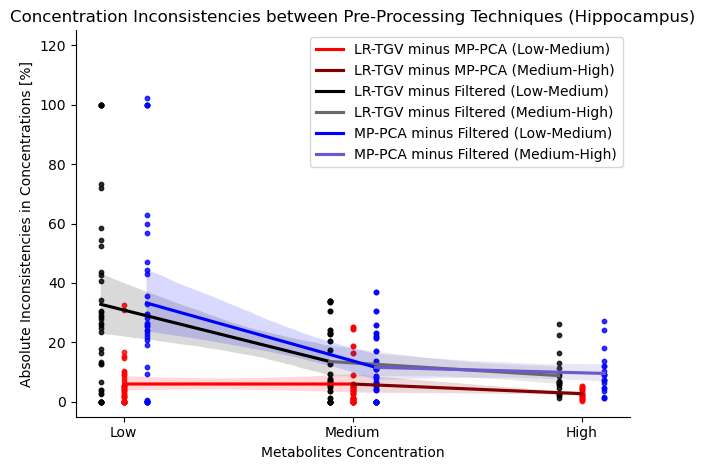

In [16]:
# Create the figure and axes
plt.close()
fig, ax = plt.subplots()

# Add the concentration groups to each dataset, converting to numerical values
MP_vs_LR_Hipp_mean['concentration_group_numeric'] = MP_vs_LR_Hipp_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)
Filtered_vs_LR_Hipp_mean['concentration_group_numeric'] = Filtered_vs_LR_Hipp_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)
Filtered_vs_MP_Hipp_mean['concentration_group_numeric'] = Filtered_vs_MP_Hipp_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)

# Set offsets for each comparison to separate their x-axis positions
offsets = {'LR-TGV minus MP-PCA': 0.0, 'LR-TGV minus Filtered': -0.1, 'MP-PCA minus Filtered': 0.1}

# Plot the regression lines between Low-Medium and Medium-High for each dataset with the respective offsets
plot_regressions(MP_vs_LR_Hipp_mean, ['red', 'maroon'], 'LR-TGV minus MP-PCA', offsets['LR-TGV minus MP-PCA'])
plot_regressions(Filtered_vs_LR_Hipp_mean, ['black', 'dimgrey'], 'LR-TGV minus Filtered', offsets['LR-TGV minus Filtered'])
plot_regressions(Filtered_vs_MP_Hipp_mean, ['blue', 'slateblue'], 'MP-PCA minus Filtered', offsets['MP-PCA minus Filtered'])

# Set the x-axis ticks and labels
ax.set_xticks([0, 1, 2])  # Positions of the 'Low', 'Medium', and 'High' concentration groups
ax.set_xticklabels(['Low', 'Medium', 'High'])  # Labels corresponding to those positions

ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_ylim([-5, 125])
ax.set_xlabel("Metabolites Concentration")
ax.set_title("Concentration Inconsistencies between Pre-Processing Techniques (Hippocampus)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()


### Plot C.4) Striatum (Grouped Concentrations)

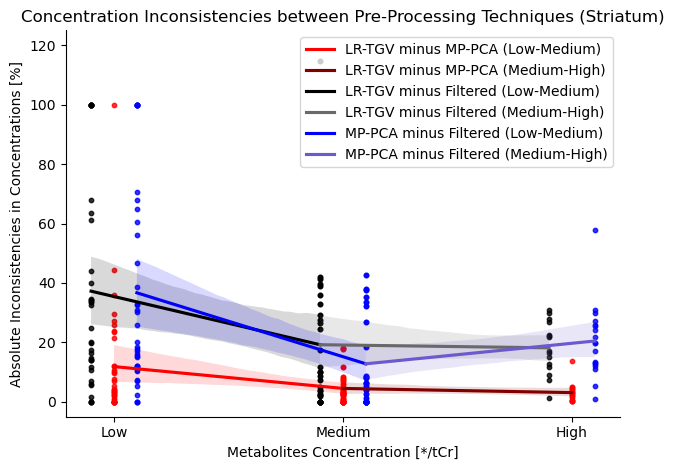

In [17]:
# Create the figure and axes
fig.clf()
fig, ax = plt.subplots()


# Add the concentration groups to each dataset, converting to numerical values
MP_vs_LR_Stri_mean['concentration_group_numeric'] = MP_vs_LR_Stri_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)
Filtered_vs_LR_Stri_mean['concentration_group_numeric'] = Filtered_vs_LR_Stri_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)
Filtered_vs_MP_Stri_mean['concentration_group_numeric'] = Filtered_vs_MP_Stri_mean.mean_conc.apply(categorize_concentration).map(concentration_mapping)

# Set offsets for each comparison to separate their x-axis positions
offsets = {'LR-TGV minus MP-PCA': 0.0, 'LR-TGV minus Filtered': -0.1, 'MP-PCA minus Filtered': 0.1}

# Plot the regression lines between Low-Medium and Medium-High for each dataset with the respective offsets
plot_regressions(MP_vs_LR_Stri_mean, ['red', 'maroon'], 'LR-TGV minus MP-PCA', offsets['LR-TGV minus MP-PCA'])
plot_regressions(Filtered_vs_LR_Stri_mean, ['black', 'dimgrey'], 'LR-TGV minus Filtered', offsets['LR-TGV minus Filtered'])
plot_regressions(Filtered_vs_MP_Stri_mean, ['blue', 'slateblue'], 'MP-PCA minus Filtered', offsets['MP-PCA minus Filtered'])

# Set the x-axis ticks and labels
ax.set_xticks([0, 1, 2])  # Positions of the 'Low', 'Medium', and 'High' concentration groups
ax.set_xticklabels(['Low', 'Medium', 'High'])  # Labels corresponding to those positions

ax.set_ylabel("Absolute Inconsistencies in Concentrations [%]")
ax.set_ylim([-5, 125])
ax.set_xlabel("Metabolites Concentration [*/tCr]")
ax.set_title("Concentration Inconsistencies between Pre-Processing Techniques (Striatum)")
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()
